In [1]:
from dagsim.baseDS import Graph, Generic
import numpy as np

from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score


In [2]:
def sig_fun(x, conf):
    z = np.exp(-(x + conf -1 + np.random.normal(scale=0.1)))
    sig = 1 / (1 + z)
    out = 1 if sig>0.5 else 0
    return out

def get_x(conf):
    if conf:
        return np.random.binomial(n=1, p=0.3)
    else:
        return np.random.binomial(n=1, p=0.6)

In [3]:
def simulate_data(p1, p2):
    conf = Generic(name="conf", function=np.random.binomial, arguments={"n": 1, "p": p1})
    X = Generic(name="X", function=get_x, arguments={"conf": conf})
    Y = Generic(name="Y", arguments={"x": X, "conf": conf}, function=sig_fun)

    listNodes = [X, conf, Y]
    my_graph = Graph("Graph1", listNodes)
    train = my_graph.simulate(num_samples=1000)
    test = my_graph.simulate(num_samples=150)

    conf = Generic(name="conf", function=np.random.binomial, arguments={"n": 1, "p": p2})
    X = Generic(name="X", function=get_x, arguments={"conf": conf})
    Y = Generic(name="Y", arguments={"x": X, "conf": conf}, function=sig_fun)
    
    listNodes = [X, conf, Y]
    my_graph = Graph("Graph1", listNodes)
    ext = my_graph.simulate(num_samples=150)

    return train, test, ext

In [4]:
def evaluate(train, test, ext):
    clf = LogisticRegression(random_state=1)

    X_tr = pd.DataFrame.from_dict(train).to_numpy()[:, 0:2]
    Y_tr = pd.DataFrame.from_dict(train).to_numpy()[:, 2]

    X_te = pd.DataFrame.from_dict(test).to_numpy()[:, 0:2]
    Y_te = pd.DataFrame.from_dict(test).to_numpy()[:, 2]

    X_ex = pd.DataFrame.from_dict(ext).to_numpy()[:, 0:2]
    Y_ex = pd.DataFrame.from_dict(ext).to_numpy()[:, 2]
    
    clf.fit(X_tr, Y_tr)

    tr_bacc = balanced_accuracy_score(clf.predict(X_tr), Y_tr)
    te_bacc = balanced_accuracy_score(clf.predict(X_te), Y_te)
    ex_bacc = balanced_accuracy_score(clf.predict(X_ex), Y_ex)
   
    tr_auprc = average_precision_score(clf.predict(X_tr), Y_tr)
    te_auprc = average_precision_score(clf.predict(X_te), Y_te)
    ex_auprc = average_precision_score(clf.predict(X_ex), Y_ex)
    
    return (tr_bacc, te_bacc, ex_bacc), (tr_auprc, te_auprc, ex_auprc)

In [5]:
def run_learning(p1, p2):
    tr_bacc_l = []
    te_bacc_l = []
    ex_bacc_l = []

    tr_auprc_l = []
    te_auprc_l = []
    ex_auprc_l = []

    for i in range(500):
        train, test, ext = simulate_data(p1, p2)
        bacc, auprc = evaluate(train, test, ext)
        tr_bacc, te_bacc, ex_bacc = bacc

        tr_bacc_l.append(tr_bacc)
        te_bacc_l.append(te_bacc)
        ex_bacc_l.append(ex_bacc)

        tr_auprc, te_auprc, ex_auprc = auprc

        tr_auprc_l.append(tr_auprc)
        te_auprc_l.append(te_auprc)
        ex_auprc_l.append(ex_auprc)

    return tr_bacc_l, te_bacc_l, ex_bacc_l, tr_auprc_l, te_auprc_l, ex_auprc_l

In [6]:
def plot_bacc(tr_bacc_l, te_bacc_l, ex_bacc_l):
    offset = 0
    mean = [a-offset for a in [np.mean(tr_bacc_l), np.mean(te_bacc_l), np.mean(ex_bacc_l)]]
    std_dev = [np.std(tr_bacc_l), np.std(te_bacc_l), np.std(ex_bacc_l)]

    plt.bar(["train", "test", "ext"], mean, yerr=std_dev, align='center',
           alpha=0.5,
           ecolor='black',
           capsize=15, bottom=offset)

In [7]:
def plot_auprc(tr_auprc_l, te_auprc_l, ex_auprc_l):
    offset = 0
    mean = [a-offset for a in [np.mean(tr_auprc_l), np.mean(te_auprc_l), np.mean(ex_auprc_l)]]
    std_dev = [np.std(tr_auprc_l), np.std(te_auprc_l), np.std(ex_auprc_l)]

    plt.bar(["train", "test", "ext"], mean, yerr=std_dev, align='center',
           alpha=0.5,
           ecolor='black',
           capsize=15, bottom=offset)

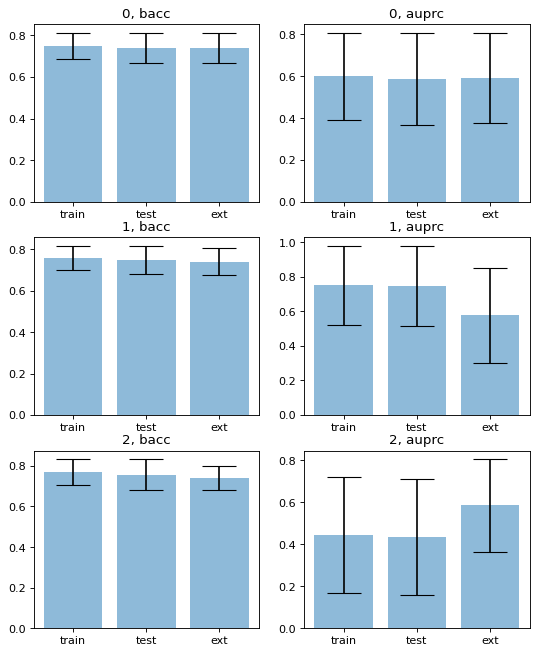

In [8]:
probs = [(0.5,0.5), (0.8, 0.2), (0.2, 0.8)]

plt.figure(figsize=(8, 10), dpi=80)

for idx, prob in enumerate(probs):
    tr_bacc_l, te_bacc_l, ex_bacc_l, tr_auprc_l, te_auprc_l, ex_auprc_l = run_learning(*prob)
    plt.subplot(3,2,2*idx+1)
    plt.title(str(idx) + ", bacc")
    plot_bacc(tr_bacc_l, te_bacc_l, ex_bacc_l)
    plt.subplot(3,2,2*idx+2)
    plt.title(str(idx) + ", auprc")
    plot_auprc(tr_auprc_l, te_auprc_l, ex_auprc_l)    